# Bước 1: Chuẩn bị Dữ liệu và Phân tích Khám phá (EDA)

**Mục tiêu:** Tải dữ liệu giá đóng cửa của 5 cổ phiếu blue-chip Việt Nam (HPG, VHM, MWG, VCB, FPT), tính log returns, xử lý dữ liệu, và thực hiện phân tích khám phá.

In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Import các hàm xử lý dữ liệu từ src/data_prep.py
import sys
sys.path.append('../src')
from data_prep import (
    load_split_adjusted_data, compute_log_returns, check_negative_or_zero,
    check_outliers, report_missing_values, save_to_csv
 )

## Tải dữ liệu giá đóng cửa của 5 cổ phiếu (15 năm gần nhất)

Lưu ý: Mã cổ phiếu Việt Nam trên Yahoo Finance thường có hậu tố '.VN' (ví dụ: HPG.VN).

In [17]:
def merge_ticker_fixed(raw_folder):
    """
    Merge với sửa lỗi cột và date format
    """
    import glob
    
    csv_files = glob.glob(os.path.join(raw_folder, "Download Data - STOCK_VN_XSTC_*.csv"))
    print(f"Found {len(csv_files)} files")
    
    # Group by ticker
    tickers = {}
    for file_path in csv_files:
        filename = os.path.basename(file_path)
        ticker = filename.split("XSTC_")[1][:3]
        
        if ticker not in tickers:
            tickers[ticker] = []
        tickers[ticker].append(file_path)
    
    print("Tickers found:", list(tickers.keys()))
    
    result = {}
    for ticker, files in tickers.items():
        print(f"\n{ticker}: {len(files)} files")
        
        all_dfs = []
        for file_path in sorted(files):
            df = pd.read_csv(file_path)
            
            # Fix 1: Lấy đúng cột Date và Close (không phải Volume)
            if 'Close' in df.columns:
                df_clean = df[['Date', 'Close']].copy()
            else:
                # Fallback: Date (col 0) và Close (col -2, not -1)
                df_clean = df.iloc[:, [0, -2]].copy()
                df_clean.columns = ['Date', 'Close']
            
            # Fix 2: Thử cả 2 date formats
            df_clean['Date'] = pd.to_datetime(df_clean['Date'], errors='coerce')
            if df_clean['Date'].isna().sum() > len(df_clean) * 0.5:  # Nếu >50% fail
                # Thử format MM/dd/yyyy
                df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%m/%d/%Y', errors='coerce')
            
            # Clean price (remove commas)
            df_clean['Close'] = pd.to_numeric(df_clean['Close'].astype(str).str.replace(',', ''), errors='coerce')
            
            # Remove invalid rows
            df_clean = df_clean.dropna()
            all_dfs.append(df_clean)
            
            print(f"  {os.path.basename(file_path)}: {len(df)} -> {len(df_clean)} rows")
        
        # Concat và remove duplicates
        if all_dfs:
            combined = pd.concat(all_dfs).drop_duplicates(subset=['Date'], keep='last')
            combined = combined.set_index('Date').sort_index()
            combined.columns = [f'{ticker}_DATA']
            result[ticker] = combined
            
            print(f"  Final: {len(combined)} rows ({combined.index.min().date()} to {combined.index.max().date()})")
    
    return result

# Test với fix
data_fixed = merge_ticker_fixed('../data/raw')

Found 55 files
Tickers found: ['FPT', 'HPG', 'MBB', 'MWG', 'VIC']

FPT: 11 files
  Download Data - STOCK_VN_XSTC_FPT (1).csv: 249 -> 249 rows
  Download Data - STOCK_VN_XSTC_FPT (10).csv: 118 -> 118 rows
  Download Data - STOCK_VN_XSTC_FPT (2).csv: 250 -> 250 rows
  Download Data - STOCK_VN_XSTC_FPT (3).csv: 251 -> 251 rows
  Download Data - STOCK_VN_XSTC_FPT (4).csv: 252 -> 252 rows
  Download Data - STOCK_VN_XSTC_FPT (5).csv: 253 -> 253 rows
  Download Data - STOCK_VN_XSTC_FPT (6).csv: 249 -> 249 rows
  Download Data - STOCK_VN_XSTC_FPT (7).csv: 249 -> 249 rows
  Download Data - STOCK_VN_XSTC_FPT (8).csv: 251 -> 251 rows
  Download Data - STOCK_VN_XSTC_FPT (9).csv: 253 -> 253 rows
  Download Data - STOCK_VN_XSTC_FPT.csv: 250 -> 250 rows
  Final: 2617 rows (2015-01-05 to 2025-07-01)

HPG: 11 files
  Download Data - STOCK_VN_XSTC_HPG (1).csv: 249 -> 249 rows
  Download Data - STOCK_VN_XSTC_HPG (10).csv: 118 -> 118 rows
  Download Data - STOCK_VN_XSTC_HPG (2).csv: 250 -> 250 rows
  Down

In [15]:
# Kết quả merge
print("=== MERGED DATA SUMMARY ===")
for ticker, df in data.items():
    print(f"{ticker}: {len(df)} rows from {df.index.min().date()} to {df.index.max().date()}")

# Combine tất cả thành 1 DataFrame  
if data:
    raw_data = pd.concat(list(data.values()), axis=1).sort_index()
    print(f"\nCombined DataFrame: {raw_data.shape}")
    print(f"Date range: {raw_data.index.min().date()} to {raw_data.index.max().date()}")
    print(f"Columns: {list(raw_data.columns)}")
else:
    raw_data = pd.DataFrame()

=== MERGED DATA SUMMARY ===
FPT: 1011 rows from 2015-01-04 to 2025-12-06
HPG: 1011 rows from 2015-01-04 to 2025-12-06
MBB: 1011 rows from 2015-01-04 to 2025-12-06
MWG: 1011 rows from 2015-01-04 to 2025-12-06
VIC: 1011 rows from 2015-01-04 to 2025-12-06

Combined DataFrame: (1011, 5)
Date range: 2015-01-04 to 2025-12-06
Columns: ['FPT_DATA', 'HPG_DATA', 'MBB_DATA', 'MWG_DATA', 'VIC_DATA']


In [16]:
def debug_data_loss(file_path):
    """
    Kiểm tra chi tiết lý do mất data trong 1 file
    """
    import pandas as pd
    
    print(f"=== DEBUGGING: {os.path.basename(file_path)} ===")
    
    # Load raw data
    df_raw = pd.read_csv(file_path)
    print(f"Raw data shape: {df_raw.shape}")
    print(f"Columns: {list(df_raw.columns)}")
    
    # Check first few rows
    print("\nFirst 3 rows:")
    print(df_raw.head(3))
    
    # Select date and price columns
    df_work = df_raw.iloc[:, [0, -1]].copy()
    df_work.columns = ['Date', 'Price']
    print(f"\nAfter selecting Date/Price columns: {len(df_work)} rows")
    
    # Check for missing values before conversion
    print(f"Missing values before conversion:")
    print(f"  Date column: {df_work['Date'].isna().sum()}")
    print(f"  Price column: {df_work['Price'].isna().sum()}")
    
    # Check date conversion
    print(f"\nOriginal Date column sample:")
    print(df_work['Date'].head(5).tolist())
    
    df_work['Date_converted'] = pd.to_datetime(df_work['Date'], dayfirst=True, errors='coerce')
    date_failed = df_work['Date_converted'].isna().sum()
    print(f"Failed date conversions: {date_failed}")
    if date_failed > 0:
        failed_dates = df_work[df_work['Date_converted'].isna()]['Date'].unique()[:5]
        print(f"Sample failed dates: {failed_dates}")
    
    # Check price conversion
    print(f"\nOriginal Price column sample:")
    print(df_work['Price'].head(5).tolist())
    
    price_cleaned = df_work['Price'].astype(str).str.replace(',', '')
    df_work['Price_converted'] = pd.to_numeric(price_cleaned, errors='coerce')
    price_failed = df_work['Price_converted'].isna().sum()
    print(f"Failed price conversions: {price_failed}")
    if price_failed > 0:
        failed_prices = df_work[df_work['Price_converted'].isna()]['Price'].unique()[:5]
        print(f"Sample failed prices: {failed_prices}")
    
    # Final valid data
    df_final = df_work.dropna(subset=['Date_converted', 'Price_converted'])
    print(f"\nFinal valid rows: {len(df_final)}")
    print(f"Data loss: {len(df_raw)} -> {len(df_final)} ({len(df_final)/len(df_raw)*100:.1f}% retained)")
    
    return df_final

# Test với 1 file FPT để xem chi tiết
sample_file = '../data/raw/Download Data - STOCK_VN_XSTC_FPT (1).csv'
debug_result = debug_data_loss(sample_file)

=== DEBUGGING: Download Data - STOCK_VN_XSTC_FPT (1).csv ===
Raw data shape: (249, 6)
Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

First 3 rows:
         Date     Open     High      Low    Close     Volume
0  07/01/2024  113,391  113,391  111,739  111,826  7,422,102
1  06/28/2024  115,478  115,478  113,391  113,478  7,627,952
2  06/27/2024  114,174  116,609  113,739  115,478  7,506,857

After selecting Date/Price columns: 249 rows
Missing values before conversion:
  Date column: 0
  Price column: 0

Original Date column sample:
['07/01/2024', '06/28/2024', '06/27/2024', '06/26/2024', '06/25/2024']
Failed date conversions: 153
Sample failed dates: ['06/28/2024' '06/27/2024' '06/26/2024' '06/25/2024' '06/24/2024']

Original Price column sample:
['7,422,102', '7,627,952', '7,506,857', '8,304,612', '16,157,665']
Failed price conversions: 0

Final valid rows: 96
Data loss: 249 -> 96 (38.6% retained)


In [18]:
def smart_date_convert(date_series):
    """
    Thử nhiều format date khác nhau
    """
    formats_to_try = [
        '%m/%d/%Y',    # MM/dd/yyyy (US format)
        '%d/%m/%Y',    # dd/MM/yyyy (EU format)  
        '%Y-%m-%d',    # yyyy-MM-dd (ISO format)
        '%d-%m-%Y',    # dd-MM-yyyy
        '%m-%d-%Y'     # MM-dd-yyyy
    ]
    
    result = pd.Series(pd.NaT, index=date_series.index)
    remaining_mask = pd.Series(True, index=date_series.index)
    
    for fmt in formats_to_try:
        if remaining_mask.sum() == 0:
            break
            
        try:
            temp_result = pd.to_datetime(date_series[remaining_mask], format=fmt, errors='coerce')
            valid_mask = temp_result.notna()
            
            if valid_mask.sum() > 0:
                result.loc[remaining_mask] = temp_result
                remaining_mask = remaining_mask & result.isna()
                print(f"  Format {fmt}: converted {valid_mask.sum()} dates")
        except:
            continue
    
    return result

def merge_ticker_smart(raw_folder):
    """
    Merge với smart date conversion
    """
    import glob
    
    csv_files = glob.glob(os.path.join(raw_folder, "Download Data - STOCK_VN_XSTC_*.csv"))
    print(f"Found {len(csv_files)} files")
    
    tickers = {}
    for file_path in csv_files:
        filename = os.path.basename(file_path)
        ticker = filename.split("XSTC_")[1][:3]
        
        if ticker not in tickers:
            tickers[ticker] = []
        tickers[ticker].append(file_path)
    
    result = {}
    for ticker, files in tickers.items():
        print(f"\n=== {ticker}: {len(files)} files ===")
        
        all_dfs = []
        for file_path in sorted(files):
            print(f"Processing {os.path.basename(file_path)}")
            df = pd.read_csv(file_path)
            
            # Get Date and Close columns
            if 'Close' in df.columns:
                df_clean = df[['Date', 'Close']].copy()
            else:
                # Assume Date is first col, Close is second-to-last col
                df_clean = df.iloc[:, [0, -2]].copy()
                df_clean.columns = ['Date', 'Close']
            
            print(f"  Raw: {len(df_clean)} rows")
            
            # Smart date conversion
            df_clean['Date'] = smart_date_convert(df_clean['Date'])
            date_na = df_clean['Date'].isna().sum()
            print(f"  Failed dates: {date_na}")
            
            # Clean price
            df_clean['Close'] = pd.to_numeric(df_clean['Close'].astype(str).str.replace(',', ''), errors='coerce')
            price_na = df_clean['Close'].isna().sum()
            print(f"  Failed prices: {price_na}")
            
            # Remove invalid
            df_clean = df_clean.dropna()
            print(f"  Final: {len(df_clean)} rows")
            
            if len(df_clean) > 0:
                all_dfs.append(df_clean)
        
        # Combine
        if all_dfs:
            combined = pd.concat(all_dfs).drop_duplicates(subset=['Date'], keep='last')
            combined = combined.set_index('Date').sort_index()
            combined.columns = [f'{ticker}_DATA']
            result[ticker] = combined
            
            print(f"FINAL {ticker}: {len(combined)} rows ({combined.index.min().date()} to {combined.index.max().date()})")
    
    return result

# Test
data_smart = merge_ticker_smart('../data/raw')

Found 55 files

=== FPT: 11 files ===
Processing Download Data - STOCK_VN_XSTC_FPT (1).csv
  Raw: 249 rows
  Format %m/%d/%Y: converted 249 dates
  Failed dates: 0
  Failed prices: 0
  Final: 249 rows
Processing Download Data - STOCK_VN_XSTC_FPT (10).csv
  Raw: 118 rows
  Format %m/%d/%Y: converted 118 dates
  Failed dates: 0
  Failed prices: 0
  Final: 118 rows
Processing Download Data - STOCK_VN_XSTC_FPT (2).csv
  Raw: 250 rows
  Format %m/%d/%Y: converted 250 dates
  Failed dates: 0
  Failed prices: 0
  Final: 250 rows
Processing Download Data - STOCK_VN_XSTC_FPT (3).csv
  Raw: 251 rows
  Format %m/%d/%Y: converted 251 dates
  Failed dates: 0
  Failed prices: 0
  Final: 251 rows
Processing Download Data - STOCK_VN_XSTC_FPT (4).csv
  Raw: 252 rows
  Format %m/%d/%Y: converted 252 dates
  Failed dates: 0
  Failed prices: 0
  Final: 252 rows
Processing Download Data - STOCK_VN_XSTC_FPT (5).csv
  Raw: 253 rows
  Format %m/%d/%Y: converted 253 dates
  Failed dates: 0
  Failed prices: 0
 

In [19]:
# So sánh kết quả
print("=== SO SÁNH KẾT QUẢ ===")
print("\nSmart merge:")
for ticker, df in data_smart.items():
    print(f"  {ticker}: {len(df)} rows")

if 'data' in locals():
    print("\nOriginal merge:")
    for ticker, df in data.items():
        print(f"  {ticker}: {len(df)} rows")

# Sử dụng data tốt nhất
final_data = data_smart
print(f"\nUsing smart merge results: {len(final_data)} tickers")

=== SO SÁNH KẾT QUẢ ===

Smart merge:
  FPT: 2617 rows
  HPG: 2617 rows
  MBB: 2617 rows
  MWG: 2617 rows
  VIC: 2617 rows

Original merge:
  FPT: 1011 rows
  HPG: 1011 rows
  MBB: 1011 rows
  MWG: 1011 rows
  VIC: 1011 rows

Using smart merge results: 5 tickers


In [20]:
# Kiểm tra format ngày đã thống nhất chưa
print("=== KIỂM TRA THỐNG NHẤT DATE FORMAT ===")

for ticker, df in final_data.items():
    print(f"\n{ticker}:")
    print(f"  Rows: {len(df)}")
    print(f"  Date range: {df.index.min()} to {df.index.max()}")
    print(f"  Index type: {type(df.index[0])}")
    
    # Kiểm tra sample dates
    sample_dates = df.index[:5]
    print(f"  Sample dates: {[d.strftime('%Y-%m-%d') for d in sample_dates]}")

# Kiểm tra overlap giữa các ticker
print(f"\n=== DATE OVERLAP CHECK ===")
all_dates = set()
ticker_dates = {}

for ticker, df in final_data.items():
    dates = set(df.index)
    ticker_dates[ticker] = dates
    all_dates.update(dates)

print(f"Total unique dates across all tickers: {len(all_dates)}")
print(f"Date range: {min(all_dates).date()} to {max(all_dates).date()}")

# Kiểm tra missing dates cho từng ticker
common_dates = set(ticker_dates[list(ticker_dates.keys())[0]])
for ticker in list(ticker_dates.keys())[1:]:
    common_dates = common_dates.intersection(ticker_dates[ticker])

print(f"Common dates across all tickers: {len(common_dates)}")

for ticker, dates in ticker_dates.items():
    missing = all_dates - dates
    print(f"{ticker}: missing {len(missing)} dates ({len(missing)/len(all_dates)*100:.1f}%)")

=== KIỂM TRA THỐNG NHẤT DATE FORMAT ===

FPT:
  Rows: 2617
  Date range: 2015-01-05 00:00:00 to 2025-07-01 00:00:00
  Index type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
  Sample dates: ['2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09']

HPG:
  Rows: 2617
  Date range: 2015-01-05 00:00:00 to 2025-07-01 00:00:00
  Index type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
  Sample dates: ['2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09']

MBB:
  Rows: 2617
  Date range: 2015-01-05 00:00:00 to 2025-07-01 00:00:00
  Index type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
  Sample dates: ['2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09']

MWG:
  Rows: 2617
  Date range: 2015-01-05 00:00:00 to 2025-07-01 00:00:00
  Index type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
  Sample dates: ['2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09']

VIC:
  Rows: 2617
  Date range: 2015-01-05 00:0

In [ ]:
# Apply different dropna strategies và xem kết quả
processed_folder = '../data/processed'
os.makedirs(processed_folder, exist_ok=True)

print("Testing different dropna strategies:")

strategies = {
    "thresh=1 (keep if any ticker has data)": 1,
    "thresh=2 (keep if at least 2 tickers)": 2,
    "thresh=3 (keep if at least 3 tickers)": 3,
    "all tickers required": len(raw_data.columns)
}

results = {}
for desc, thresh in strategies.items():
    cleaned = raw_data.dropna(thresh=thresh)
    results[desc] = cleaned
    print(f"{desc}: {len(cleaned)} rows")
    if len(cleaned) > 0:
        print(f"  Date range: {cleaned.index.min()} to {cleaned.index.max()}")

# Choose strategy (recommend thresh=2 or 3)
chosen_strategy = "thresh=2 (keep if at least 2 tickers)"
data = results[chosen_strategy].copy()

print(f"\nChosen strategy: {chosen_strategy}")
print(f"Final data shape: {data.shape}")

In [ ]:
# Remove rows with closing price <= 0 và clean data
print("Cleaning data...")
original_shape = data.shape

# Check for negative or zero prices
negative_mask = (data <= 0).any(axis=1)
if negative_mask.sum() > 0:
    print(f"Found {negative_mask.sum()} rows with price <= 0, removing...")
    data = data[~negative_mask]

print(f"Shape after cleaning: {original_shape} -> {data.shape}")

# Save cleaned price data
price_path = os.path.join(processed_folder, 'price_cleaned.csv')
data.to_csv(price_path)
print(f"Saved cleaned price data to {price_path}")

# Compute log returns
log_returns = np.log(data / data.shift(1)).dropna()
log_returns = log_returns.round(6)

print(f"Log returns shape: {log_returns.shape}")
print(f"Log returns date range: {log_returns.index.min()} to {log_returns.index.max()}")

# Save log returns
logret_path = os.path.join(processed_folder, 'log_returns.csv')
log_returns.to_csv(logret_path)
print(f"Saved log returns to {logret_path}")

print("Data preparation completed!")

## Phân tích khám phá: Vẽ biểu đồ log returns và tính thống kê mô tả

In [4]:
log_returns.describe()

,FPT_DATA,HPG_DATA,MBB_DATA,MWG_DATA,VIC_DATA
count,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000
mean,0.002270,0.001940,0.001877,0.001754,0.001466
std,0.135529,0.182719,0.134954,0.174434,0.169357
min,-0.603012,-0.671122,-0.698383,-0.832329,-0.895859
25%,-0.033741,-0.067893,-0.048102,-0.057865,-0.056844
50%,0.023271,0.018526,0.006890,0.026384,-0.000438
75%,0.072754,0.085287,0.071087,0.099554,0.066230
max,0.301487,1.061033,0.487446,0.554945,0.644829


In [5]:
# Tính các thống kê mô tả
desc_stats = log_returns.agg(['std', 'skew', 'kurtosis']).T
desc_stats

,std,skew,kurtosis
FPT_DATA,0.135529,-1.686367,4.550653
HPG_DATA,0.182719,-0.039999,5.255095
MBB_DATA,0.134954,-1.167986,5.100337
MWG_DATA,0.174434,-1.217878,3.623462
VIC_DATA,0.169357,-1.026292,7.103677


--- FPT_DATA ---


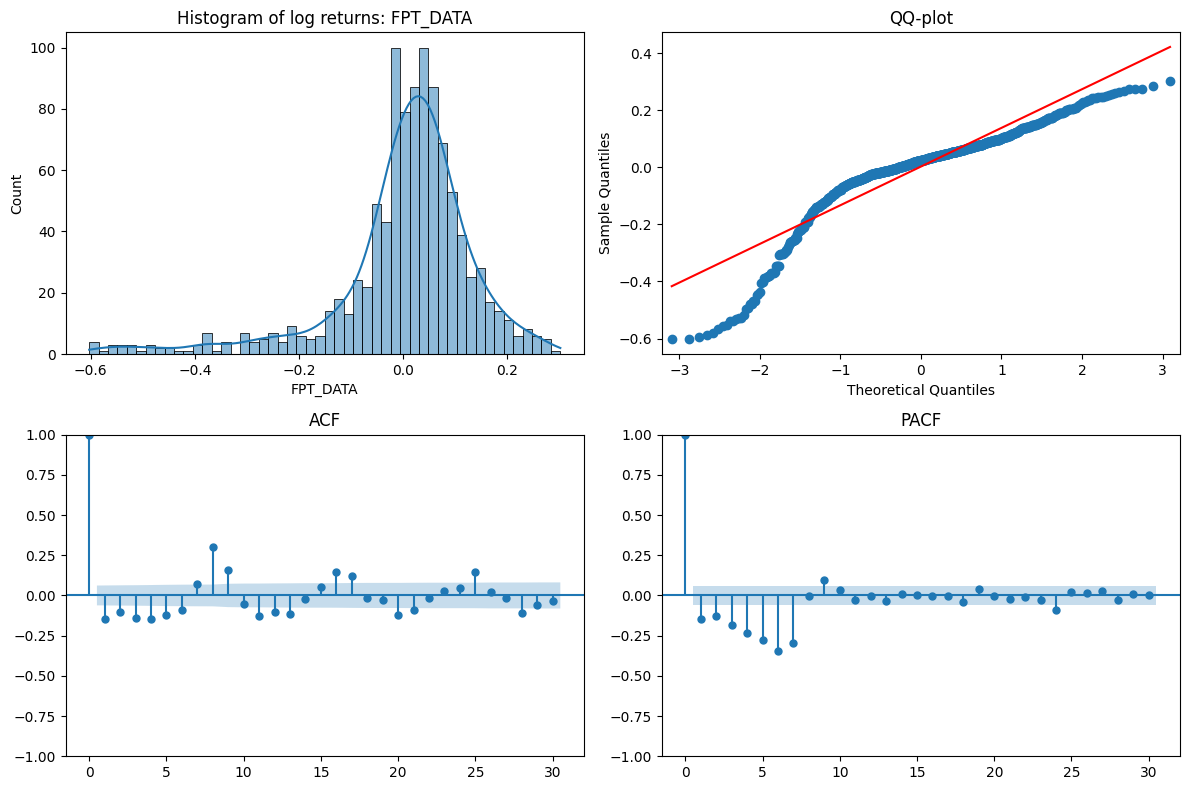


--- HPG_DATA ---


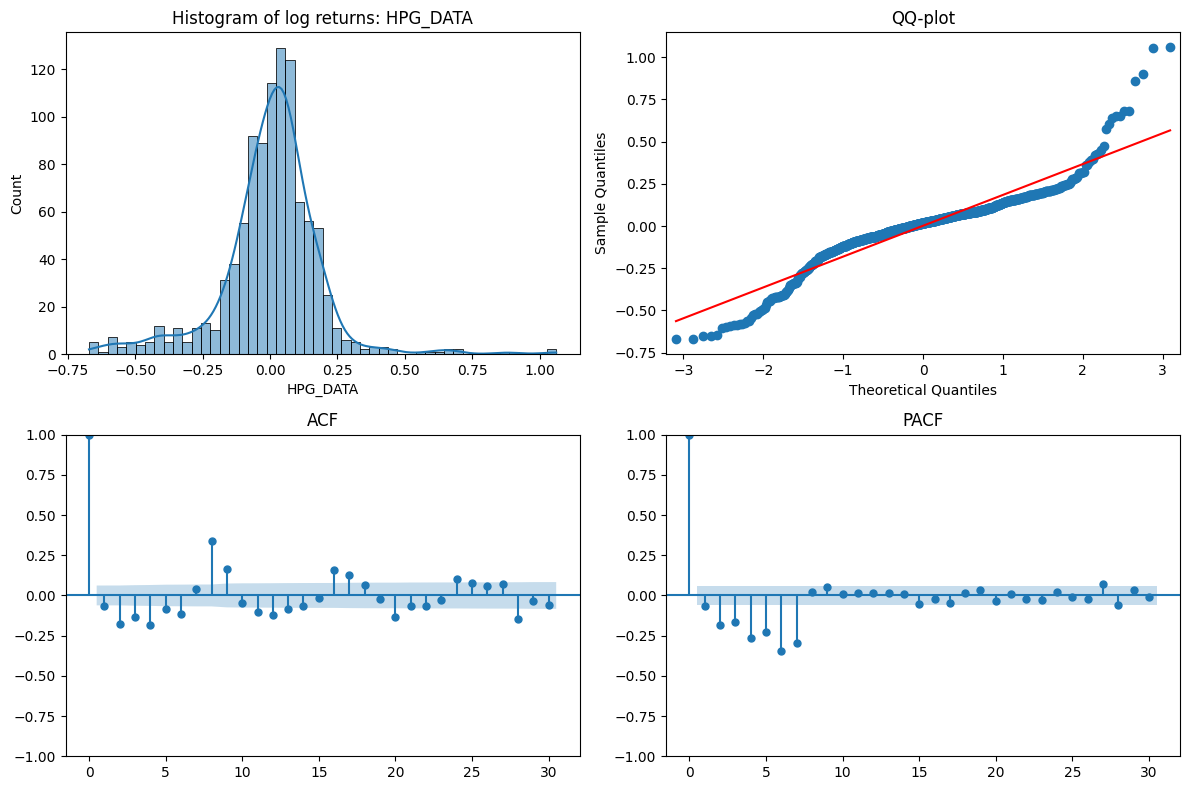


--- MBB_DATA ---


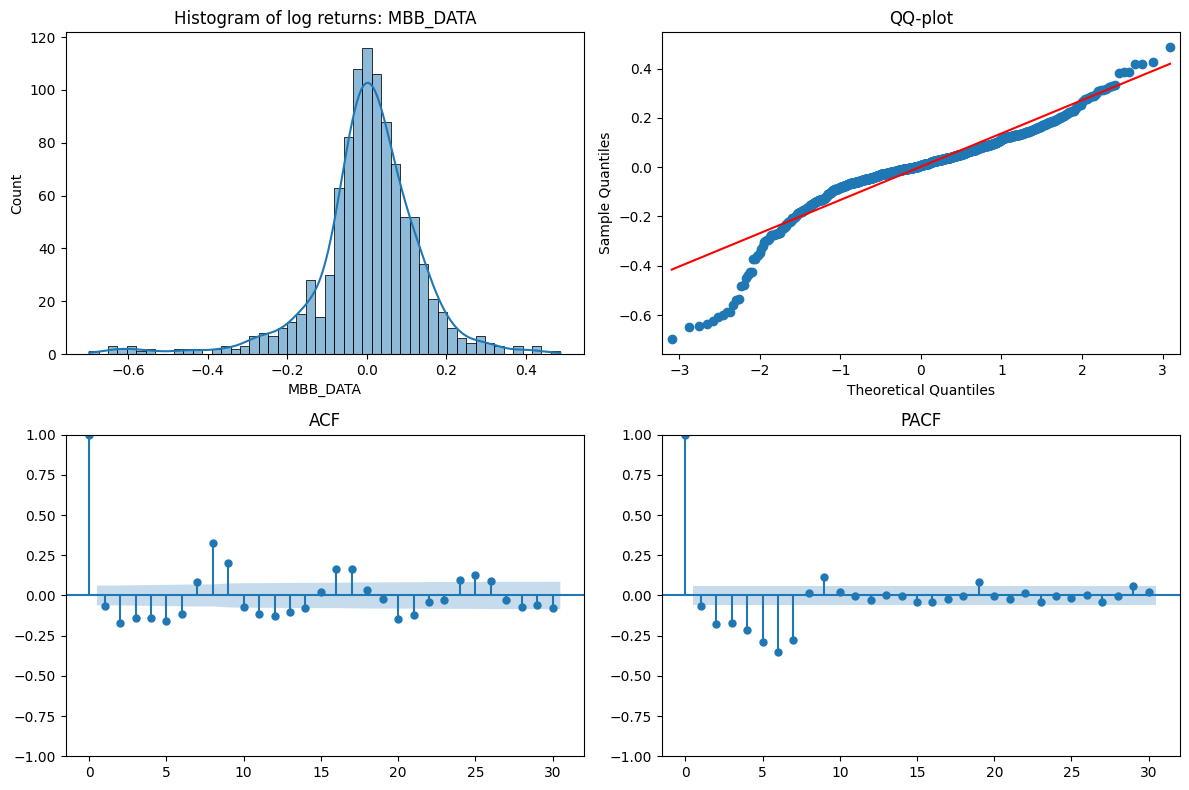


--- MWG_DATA ---


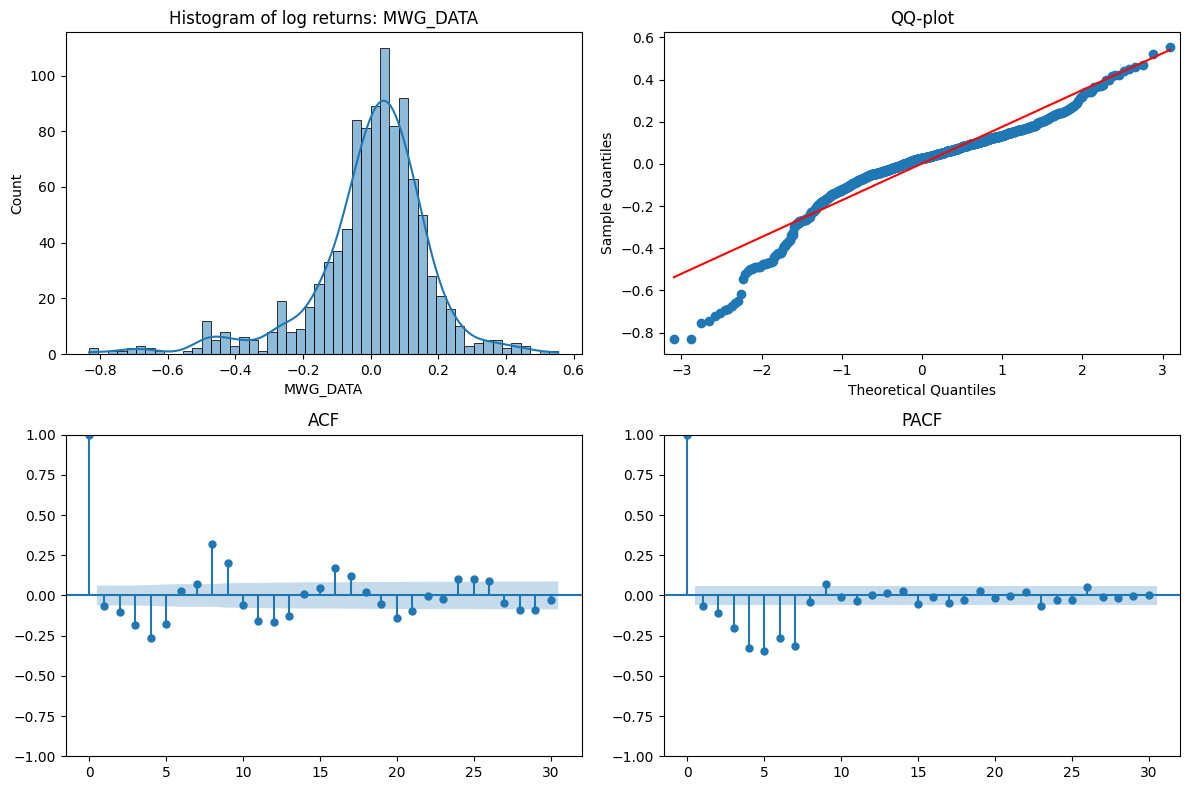


--- VIC_DATA ---


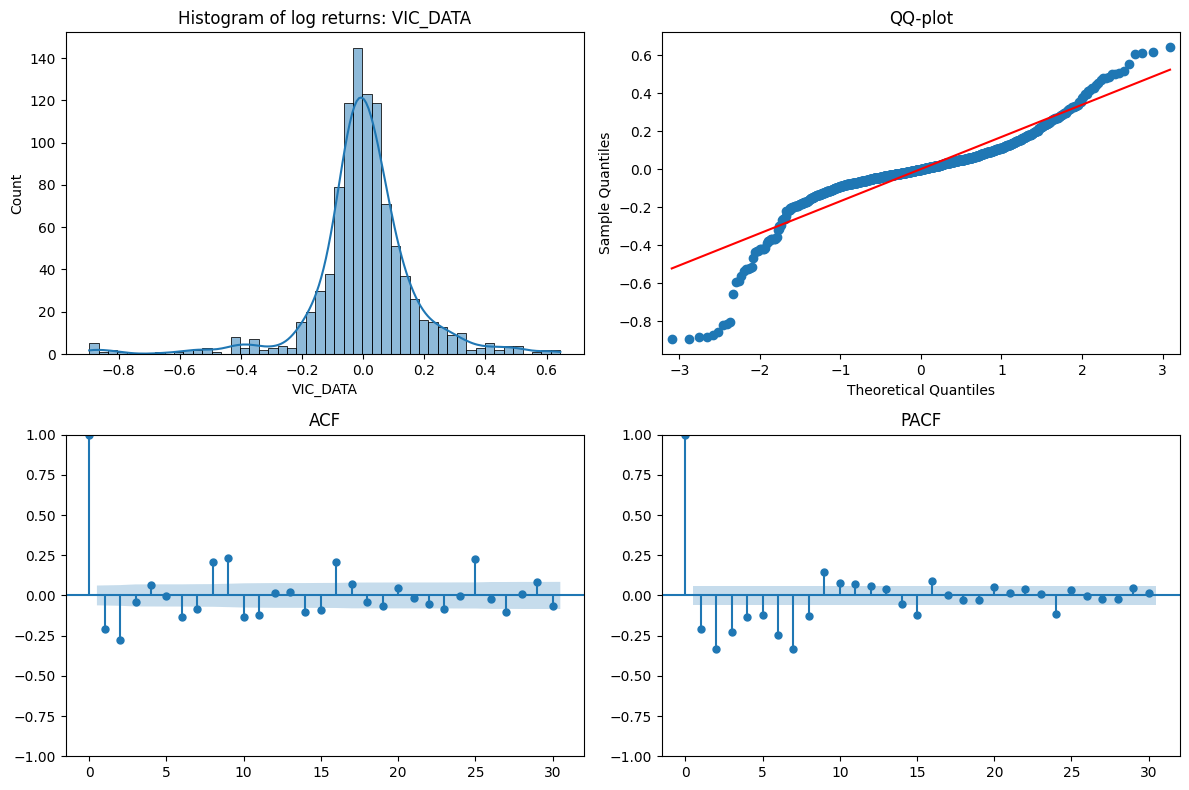

In [6]:
# Phân tích khám phá log returns cho từng cổ phiếu
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
tickers = log_returns.columns.tolist()

for ticker in tickers:
    print(f'--- {ticker} ---')
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    # Histogram
    sns.histplot(log_returns[ticker].dropna(), bins=50, kde=True, ax=axes[0,0])
    axes[0,0].set_title(f'Histogram of log returns: {ticker}')
    # QQ-plot
    sm.qqplot(log_returns[ticker].dropna(), line='s', ax=axes[0,1])
    axes[0,1].set_title('QQ-plot')
    # ACF
    plot_acf(log_returns[ticker].dropna(), ax=axes[1,0], lags=30)
    axes[1,0].set_title('ACF')
    # PACF
    plot_pacf(log_returns[ticker].dropna(), ax=axes[1,1], lags=30, method='ywm')
    axes[1,1].set_title('PACF')
    plt.tight_layout()
    plt.show()

    print()

In [7]:
from scipy.stats import normaltest, jarque_bera
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from statsmodels.tsa.stattools import adfuller

results = []
for ticker in log_returns.columns:
    x = log_returns[ticker].dropna()
    dag_stat, dag_p = normaltest(x)
    jb_stat, jb_p = jarque_bera(x)
    arch_stat, arch_p, _, _ = het_arch(x)
    adf_stat, adf_p, _, _, _, _ = adfuller(x)
    # Sử dụng return_df=True để lấy đúng p-value
    lb_result = acorr_ljungbox(x, lags=[10], return_df=True)
    lb_p_value = lb_result['lb_pvalue'].iloc[0]
    results.append({
        'Ticker': ticker,
        'D’Agostino p-value': round(dag_p, 3),
        'Jarque-Bera p-value': round(jb_p, 3),
        'ARCH p-value': round(arch_p, 3),
        'ADF p-value': round(adf_p, 3),
        'Ljung-Box p-value (lag10)': round(lb_p_value, 3)
    })

test_results = pd.DataFrame(results).set_index('Ticker')
test_results

,D’Agostino p-value,Jarque-Bera p-value,ARCH p-value,ADF p-value,Ljung-Box p-value (lag10)
Ticker,,,,,
FPT_DATA,0.0,0.0,0.0,0.0,0.0
HPG_DATA,0.0,0.0,0.0,0.0,0.0
MBB_DATA,0.0,0.0,0.0,0.0,0.0
MWG_DATA,0.0,0.0,0.0,0.0,0.0
VIC_DATA,0.0,0.0,0.0,0.0,0.0


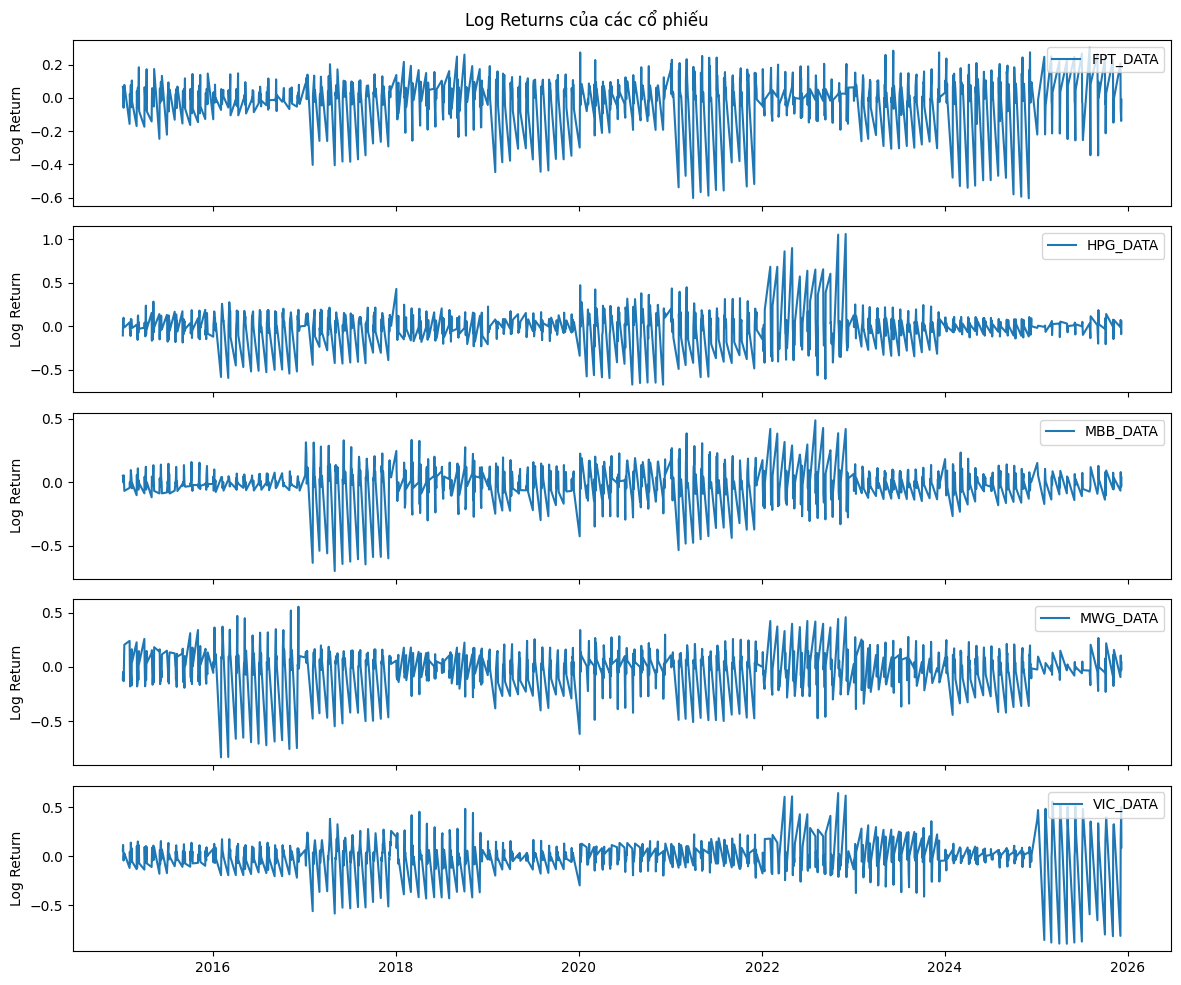

In [8]:
fig, axes = plt.subplots(len(tickers), 1, figsize=(12, 2*len(tickers)), sharex=True)
for i, ticker in enumerate(tickers):
    axes[i].plot(log_returns.index, log_returns[ticker], label=ticker)
    axes[i].set_ylabel('Log Return')
    axes[i].legend(loc='upper right')
plt.suptitle('Log Returns của các cổ phiếu')
plt.tight_layout()
plt.show()

In [21]:
# Thống kê mở rộng cho log returns
def calc_stats(df):
    stats = pd.DataFrame(index=df.columns)
    stats['VaR_5%'] = df.quantile(0.05)
    stats['sharpe'] = df.mean() / df.std()
    stats['autocorr_lag1'] = df.apply(lambda x: x.autocorr(lag=1))
    stats['num_pos'] = (df > 0).sum()
    stats['num_neg'] = (df < 0).sum()
    return stats.round(6)

desc_stats_ext = calc_stats(log_returns)
desc_stats_ext

,VaR_5%,sharpe,autocorr_lag1,num_pos,num_neg
FPT_DATA,-0.022654,0.057837,0.004220,1344,1218
HPG_DATA,-0.032055,0.034762,0.045657,1303,1267
MWG_DATA,-0.032411,0.045660,0.086653,1334,1201
VCB_DATA,-0.025828,0.028778,0.006646,1289,1245
VIC_DATA,-0.027380,0.023000,0.074642,1209,1196


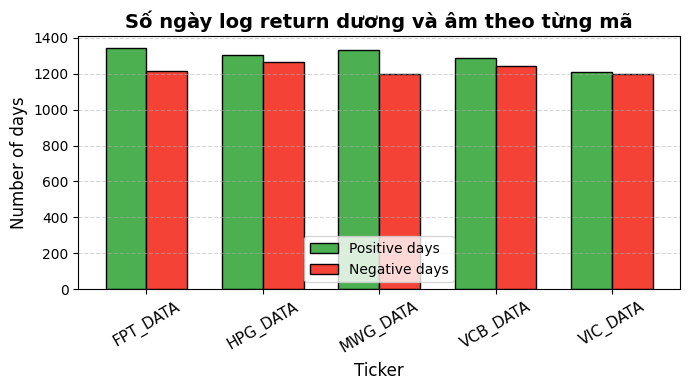

In [19]:
import matplotlib.pyplot as plt

# Tính số ngày positive và negative cho từng mã
num_pos = (log_returns > 0).sum()
num_neg = (log_returns < 0).sum()

# Vẽ biểu đồ bar với màu sắc đẹp hơn
fig, ax = plt.subplots(figsize=(7, 4))
bar_width = 0.35
index = np.arange(len(log_returns.columns))

ax.bar(index, num_pos, bar_width, label='Positive days', color='#4CAF50', edgecolor='black')
ax.bar(index + bar_width, num_neg, bar_width, label='Negative days', color='#F44336', edgecolor='black')

ax.set_xlabel('Ticker', fontsize=12)
ax.set_ylabel('Number of days', fontsize=12)
ax.set_title('Số ngày log return dương và âm theo từng mã', fontsize=14, fontweight='bold')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(log_returns.columns, rotation=30, fontsize=11)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

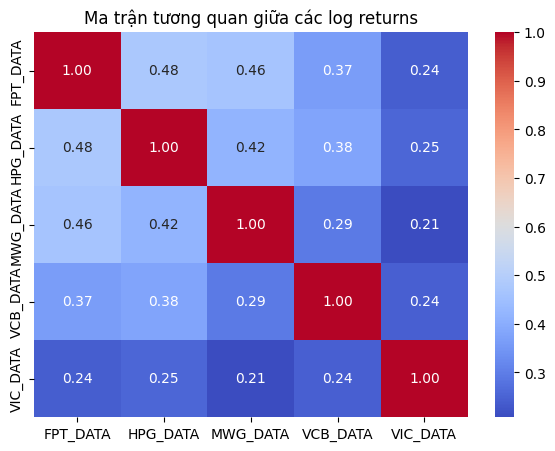

In [37]:
# 1. Ma trận tương quan
corr_matrix = log_returns.corr()
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Ma trận tương quan giữa các log returns")
plt.show()

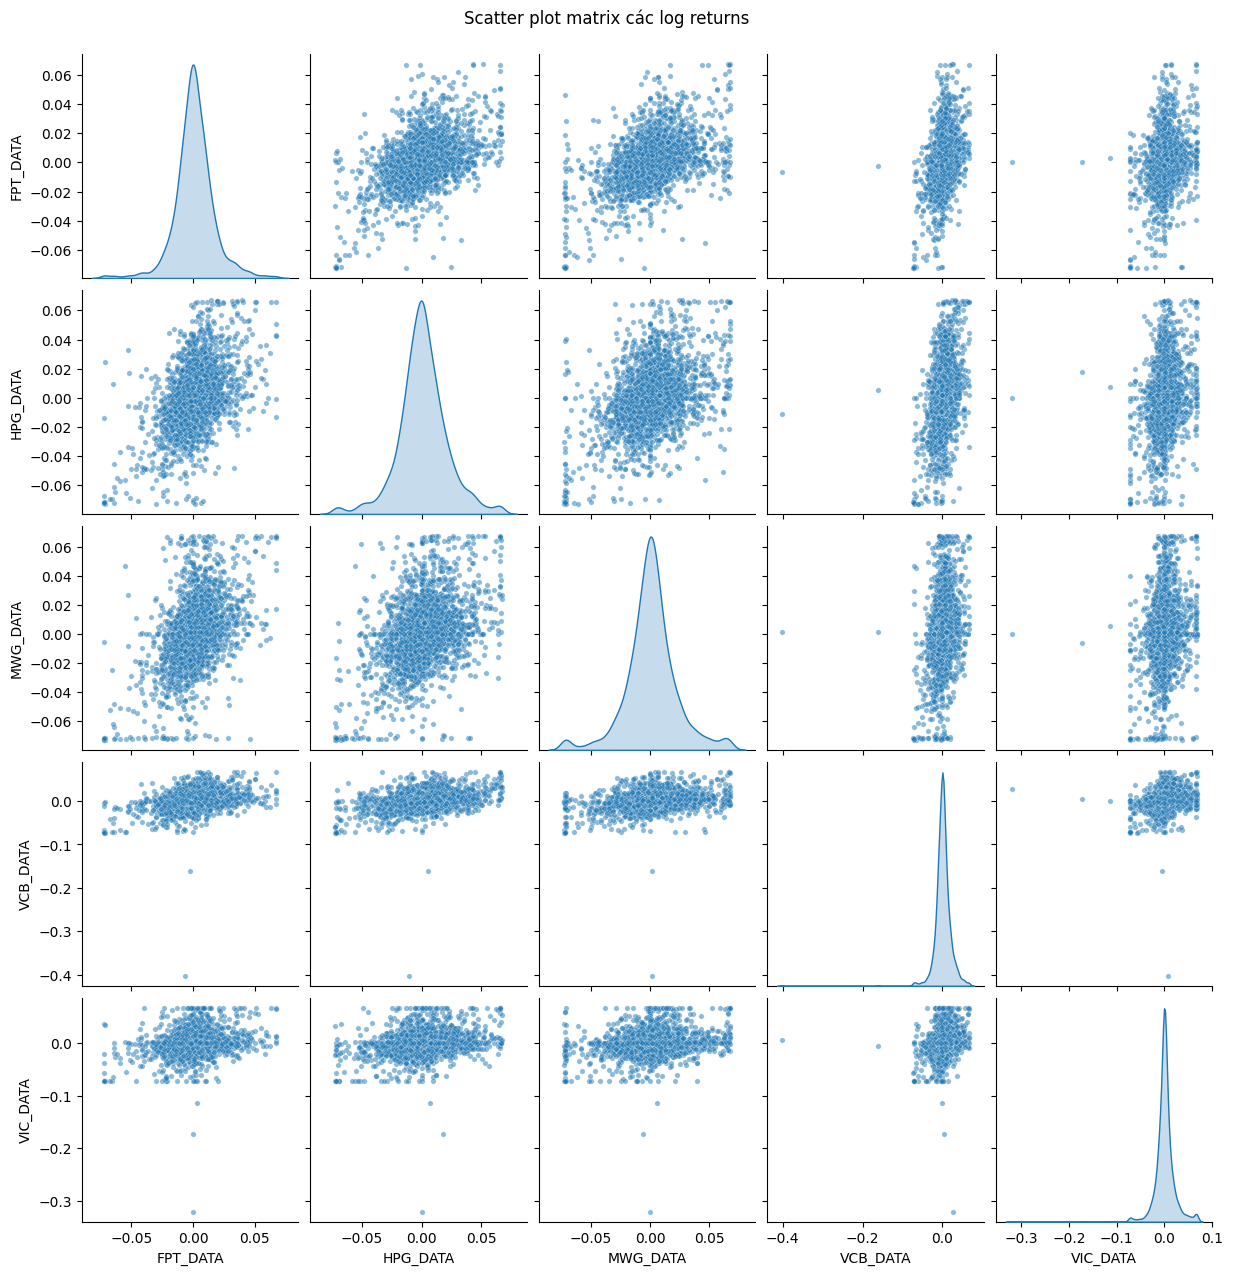

In [36]:
# 2. Biểu đồ phân tán (scatter plot matrix)
sns.pairplot(log_returns, diag_kind='kde', plot_kws={'alpha':0.5, 's':15})
plt.suptitle("Scatter plot matrix các log returns", y=1.02)
plt.show()

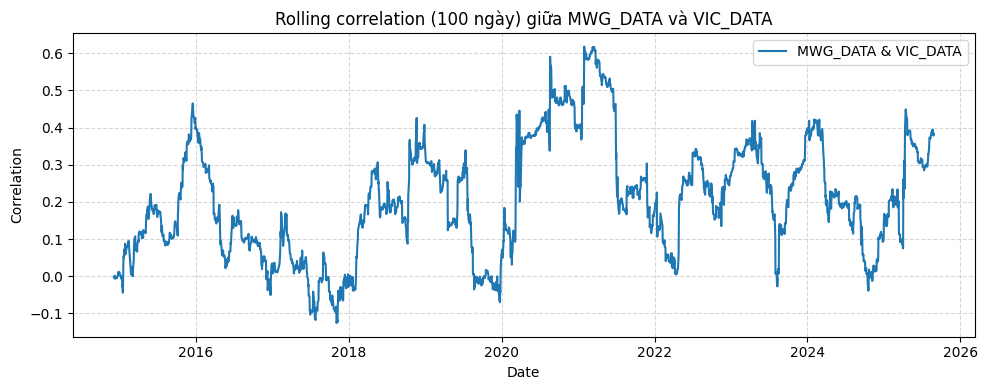

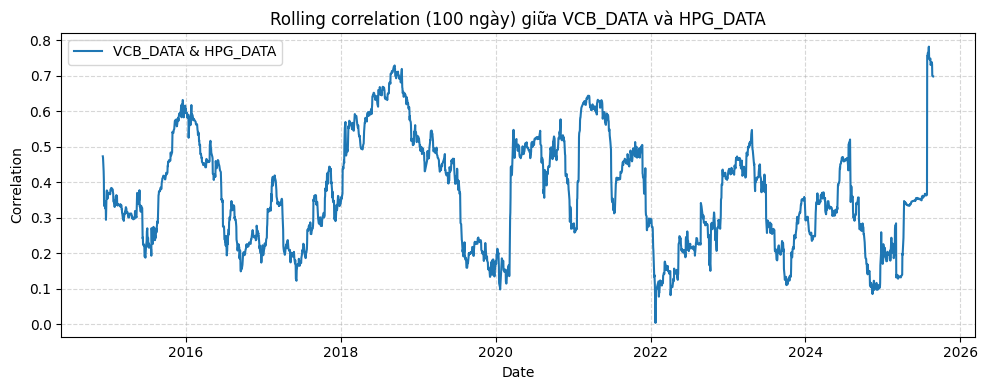

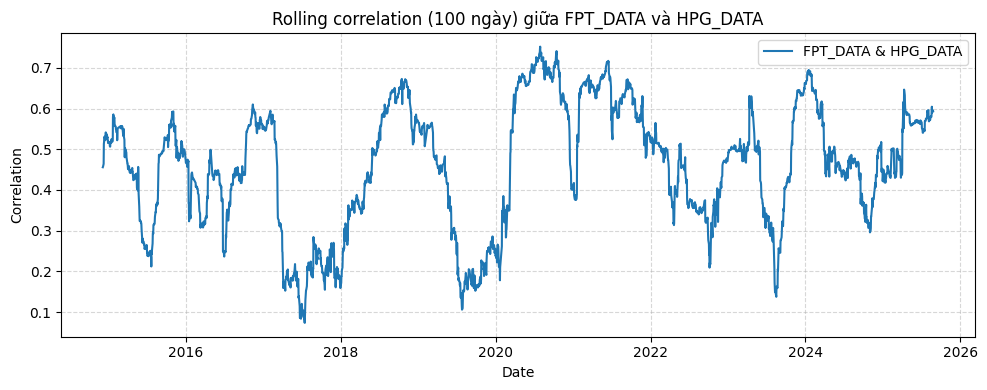

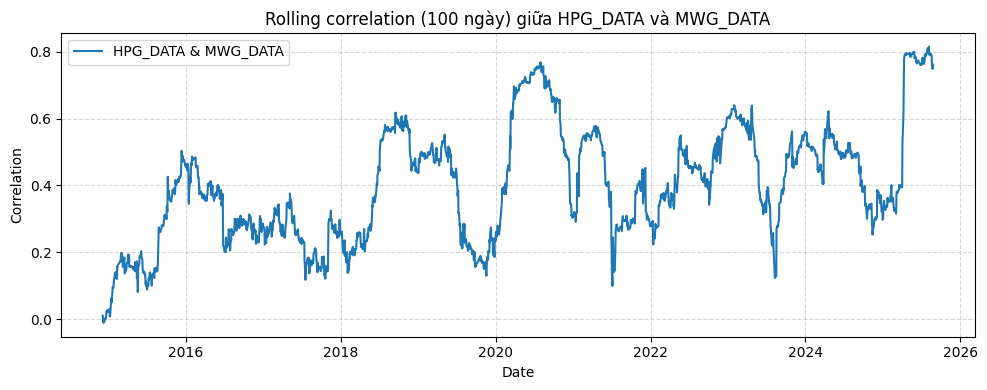

In [44]:
window = 100
pairs = [('MWG_DATA', 'VIC_DATA'), ('VCB_DATA', 'HPG_DATA'), ('FPT_DATA', 'HPG_DATA'), ('HPG_DATA', 'MWG_DATA')]

for pair in pairs:
    rolling_corr = log_returns[pair[0]].rolling(window).corr(log_returns[pair[1]])
    plt.figure(figsize=(10, 4))
    plt.plot(rolling_corr, label=f'{pair[0]} & {pair[1]}')
    plt.title(f'Rolling correlation ({window} ngày) giữa {pair[0]} và {pair[1]}')
    plt.xlabel('Date')
    plt.ylabel('Correlation')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()